- XGBoost : 병렬처리를 지원하고 빠름, GPU 지원
    - 내부적으로 결측치에 대응하는 알고리즘이 있어 결측치 처리도 가능
        - 가능한 직접 정제 권장

In [1]:
import sys
sys.path.append("Y:\Python\Mega_IT")

from yjk_module.preprocessing import *
from yjk_module.ml_module import *

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

from hossam.util import *
from hossam.plot import *
from hossam.analysis import *
from hossam.classification import *
from hossam.regression import *

from xgboost import XGBRegressor, XGBClassifier, plot_importance, to_graphviz
from sklearn.model_selection import RandomizedSearchCV

In [3]:
origin1 = pd.read_excel("./data/pima_indians_diabetes.xlsx")
origin1.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
# 정제 대상 필드명
zero_features = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# 0값을 결측치로 대체후 평균으로 다시 치환
df1 = origin1.copy()
df1[zero_features] = df1[zero_features].replace(0, np.nan)
df1_2 = my_replace_missing_value(df1)

# 결과확인
total_count = len(origin1)

for feature in zero_features:
    zero_count = origin1[origin1[feature] == 0][feature].count()
    print(
        "{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %".format(
            feature, zero_count, 100 * zero_count / total_count
        )
    )

print("---" * 30)

for feature in zero_features:
    zero_count = df1_2[df1_2[feature] == 0][feature].count()
    print(
        "{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %".format(
            feature, zero_count, 100 * zero_count / total_count
        )
    )

Glucose 0 건수는 5, 퍼센트는 0.65 %
BloodPressure 0 건수는 35, 퍼센트는 4.56 %
SkinThickness 0 건수는 227, 퍼센트는 29.56 %
Insulin 0 건수는 374, 퍼센트는 48.70 %
BMI 0 건수는 11, 퍼센트는 1.43 %
------------------------------------------------------------------------------------------
Glucose 0 건수는 0, 퍼센트는 0.00 %
BloodPressure 0 건수는 0, 퍼센트는 0.00 %
SkinThickness 0 건수는 0, 퍼센트는 0.00 %
Insulin 0 건수는 0, 퍼센트는 0.00 %
BMI 0 건수는 0, 퍼센트는 0.00 %


In [5]:
x_train, x_test, y_train, y_test = my_train_test_split(df1_2, "Outcome", scalling=True)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(614, 8) (154, 8) (614,) (154,)


- XGB 모델 적합

In [6]:
import xgboost as xgb

In [7]:
dtrain = xgb.DMatrix(data = x_train, label = y_train, feature_names = list(x_train.columns))
dtest = xgb.DMatrix(data = x_test, label = y_test, feature_names = list(x_test.columns))
dtrain, dtest

(<xgboost.core.DMatrix at 0x254c415c690>,
 <xgboost.core.DMatrix at 0x254c4113e50>)

In [8]:
wlist = [(dtrain, 'train'), (dtest, 'eval')]

In [9]:
estimator = xgb.train(
    params = {
        'booster' : 'gbtree',
        'device' : 'cpu',
        'eta' : 0.1, # 학습률
        'max_depth' : 3, # 트리 깊이
        # 목적함수 : binary:logistic, multi:softmax, multi:softprob
        'objective' : 'binary:logistic',
        # 평가지표
        'eval_metric' : 'error',
        'early_stoppings' : 5 # 얼리스타핑
    },
    dtrain = dtrain,
    num_boost_round = 400, # 부스팅 반복횟수
    evals = wlist,
    verbose_eval = True
)

[0]	train-error:0.35993	eval-error:0.30519
[1]	train-error:0.35993	eval-error:0.30519
[2]	train-error:0.35993	eval-error:0.30519
[3]	train-error:0.27199	eval-error:0.22078
[4]	train-error:0.26710	eval-error:0.22078
[5]	train-error:0.26710	eval-error:0.22078
[6]	train-error:0.26221	eval-error:0.20130
[7]	train-error:0.22313	eval-error:0.21429
[8]	train-error:0.22150	eval-error:0.18831
[9]	train-error:0.21336	eval-error:0.18182
[10]	train-error:0.20358	eval-error:0.18831
[11]	train-error:0.21336	eval-error:0.20130
[12]	train-error:0.20521	eval-error:0.20779
[13]	train-error:0.20521	eval-error:0.21429
[14]	train-error:0.20684	eval-error:0.21429
[15]	train-error:0.20195	eval-error:0.20130
[16]	train-error:0.19381	eval-error:0.19481
[17]	train-error:0.18730	eval-error:0.19481
[18]	train-error:0.18730	eval-error:0.19481
[19]	train-error:0.19544	eval-error:0.19481
[20]	train-error:0.18893	eval-error:0.19481
[21]	train-error:0.18893	eval-error:0.19481
[22]	train-error:0.19055	eval-error:0.1883

- 예측은 확률값으로 나타남

In [10]:
pred_probs = estimator.predict(data = dtest)
print(np.round(a = pred_probs[:10], decimals = 3))

[0.974 0.059 0.014 0.868 0.027 0.007 0.805 0.985 0.077 0.432]


In [11]:
preds = [1 if x > 0.5 else 0 for x in pred_probs]
print(preds[:10])

[1, 0, 0, 1, 0, 0, 1, 1, 0, 0]


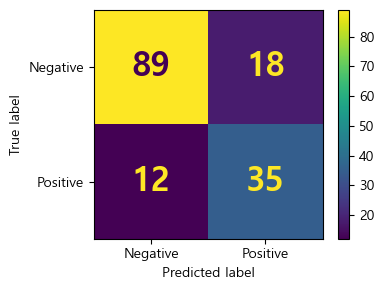

In [12]:
my_confusion_matrix(y_test, preds)

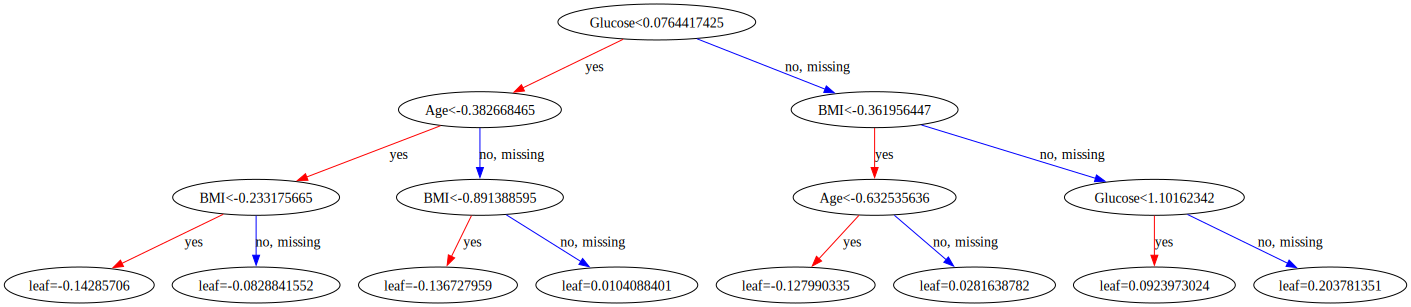

In [13]:
xgb.to_graphviz(estimator)

- XGB 하이퍼파라미터 종류
    - General : 시스템 관련설정. 거의 기본값
        - booster : 부스팅을 적용할 기본 모형
        - n_jobs : 할당 스레드 수
    - Train : 학습에 활용되는 객체함수, 모형의 평가를 위한 파라미터, 객체의 fit 메서드를 호출하면서 사용할 수도 있음
        - objective : reg:squarederror(제곱손실 회귀), binary:logistic(이진로지스틱회귀), multi:softmax(소프트맥스 다중분류)
        - eval_metric : 평가지표, 필요한 기준으로 선정하여 사용
            - 회귀 : rmse, mae, mape, logloss
            - 분류 : error(이진), merror(다중), mlogloss, auc
    - Boost : 모형 성능에 영향을 줌, 주 튜닝 대상이 됨, 파라미터 개수가 많음
        - learning_rate : 학습률, 경사하강 과정에서 이동하는 좌표의 정도를 설정, 높을수록 학습이 빠르고 과적합이 일어날 수 있음, 낮으면 정확도는 높으나 학습이 오래걸림
        - n_estimators : 학습에 사용할 약한 학습의 수(반복 횟수, 에포크)
        - min_chile_weight : 트리 분할을 결정하는 관측치의 최소 가중치 (과적합 조정용)
        - max_depth : 트리 깊이 (과적합에 크게 관여)
        - 그외 다수 파라미터 존재

- 과적합 해결 방법들
    1. learning_rate 값 낮추고 num_round(n_estimator)를 높임
    2. max_depth 낮춤
    3. min_child_weight 높임
    4. subsample과 colsample_bytree 를 조정

In [14]:
%%time

estimator = XGBClassifier(
    # General
    booster = "gbtree",
    device = "cpu",
    verbosity = 1,

    # Train
    objective = "binary:logistic",
    eval_metric = "error",

    # Booster
    learning_rate = 0.3,
    n_estimators = 100,
    min_child_weight = 1,
    gamma = 0,
    max_depth = 6,
    early_stopping_rounds = 10
)

estimator.fit(x_train, y_train, eval_set = [(x_train, y_train), (x_test, y_test)])

[0]	validation_0-error:0.23127	validation_1-error:0.25974
[1]	validation_0-error:0.16775	validation_1-error:0.21429
[2]	validation_0-error:0.14007	validation_1-error:0.22727
[3]	validation_0-error:0.11238	validation_1-error:0.20130
[4]	validation_0-error:0.09935	validation_1-error:0.21429
[5]	validation_0-error:0.08795	validation_1-error:0.19481
[6]	validation_0-error:0.08306	validation_1-error:0.20779
[7]	validation_0-error:0.07818	validation_1-error:0.19481
[8]	validation_0-error:0.07003	validation_1-error:0.18831
[9]	validation_0-error:0.06515	validation_1-error:0.20779
[10]	validation_0-error:0.06026	validation_1-error:0.20130
[11]	validation_0-error:0.05537	validation_1-error:0.20779
[12]	validation_0-error:0.04886	validation_1-error:0.20779
[13]	validation_0-error:0.05212	validation_1-error:0.20779
[14]	validation_0-error:0.04886	validation_1-error:0.20779
[15]	validation_0-error:0.03746	validation_1-error:0.20130
[16]	validation_0-error:0.03583	validation_1-error:0.19481
[17]	va

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cpu', early_stopping_rounds=10,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

[분류분석 성능평가]
+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |     0.929967 |     0.811688 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |     0.927885 |     0.695652 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재현율(Recall)    |     0.873303 |     0.680851 | 실제 양성(TP,FN) 중 양성(TP)으로 예측한 비율              |
| 위양성율(Fallout) |    0.0381679 |     0.130841 | 실제 음성(FP,TN) 중 양성(FP)으로 잘못 예측한 비율         |
| 특이성(TNR)       |     0.961832 |     0.869159 | 실제 음성(FP,TN) 중 음성(TN)으로 정확히 예측한 비율       |
| F1 Score          |     0.899767 |     0.688172 | 정밀도와 재현율의 조화평균                                |
| AUC               |     0.979034 |     0.849672 | ROC Curve의 면적으로, 1에 가까울수록 좋은 모델            |
+--

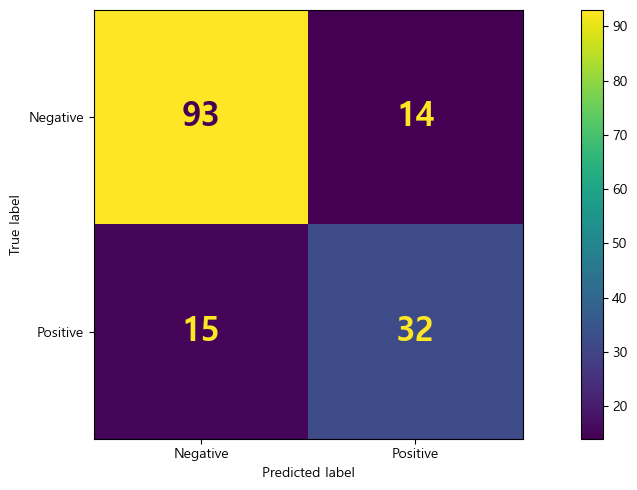


[변수 중요도]


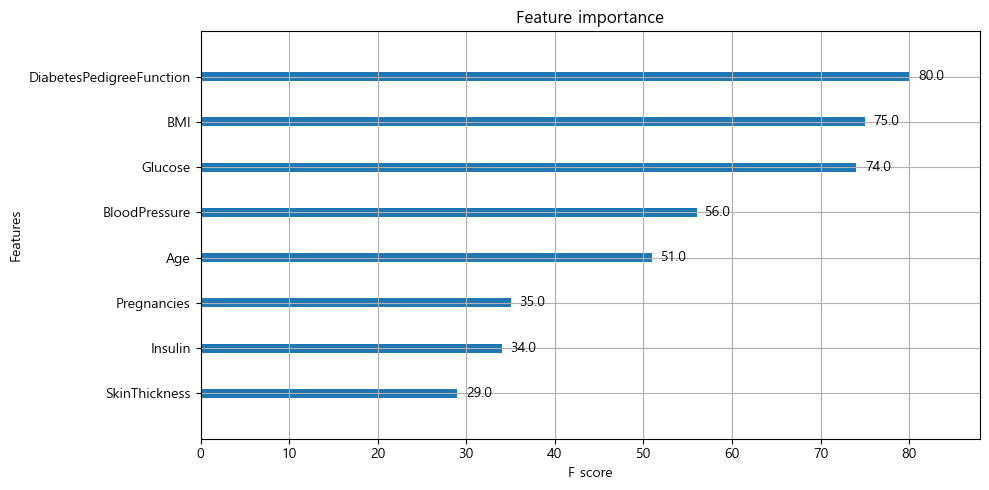


[Roc Curve]


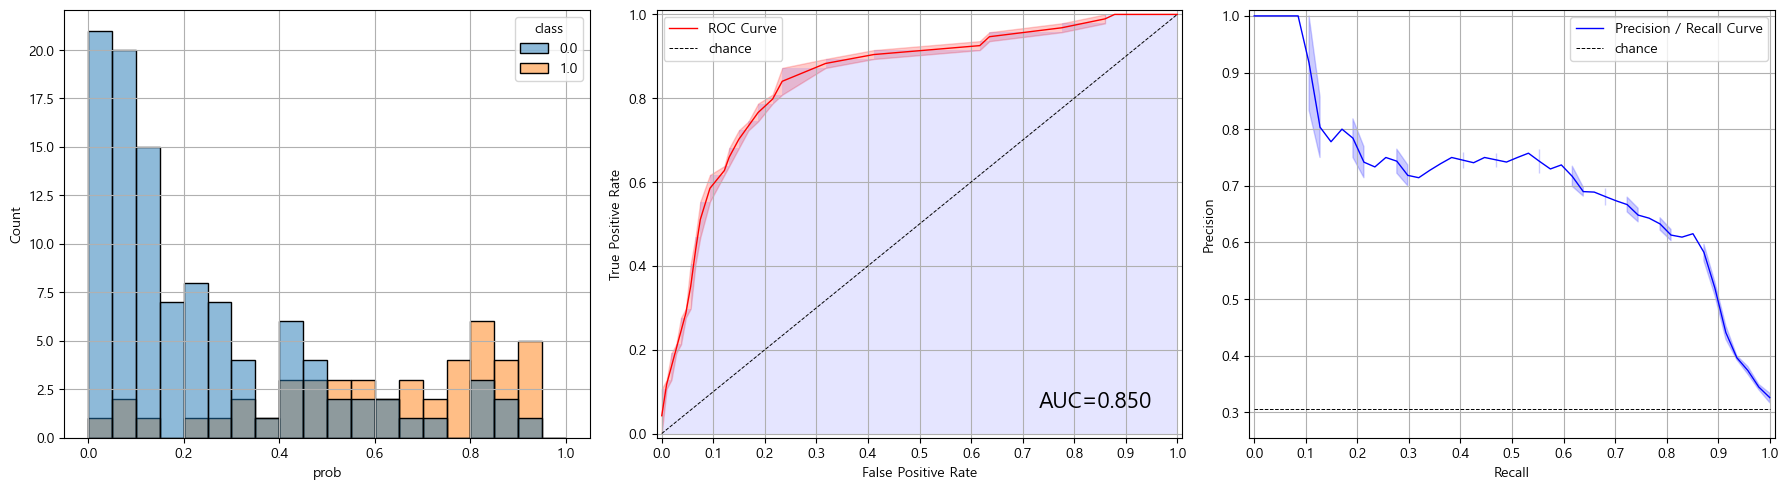


[학습곡선]


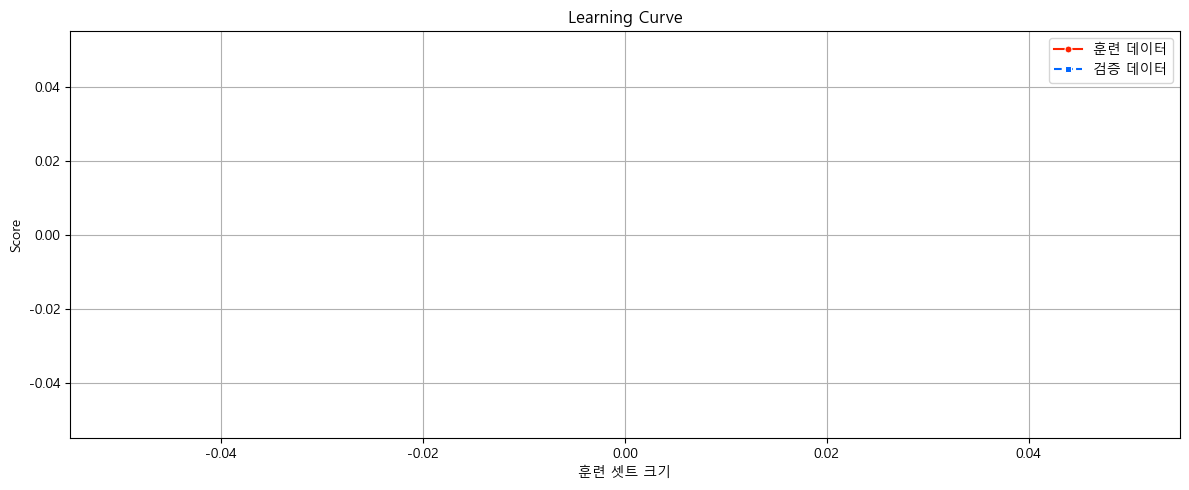

In [15]:
my_classification_result(estimator, x_train, y_train, x_test, y_test)

- 모델 훈련에서 손실은 학습을 진행할수록 감소
- 모델이 학습을 반복하면 훈련, 검증 데이터에 대한 에러는 감소하지만 모델이 노이즈를 학습하게 되면 곡선 사이에 간격이 생김
    - 모델이 얼마나 많은 노이즈를 학습했는지를 의미함 (과적합)

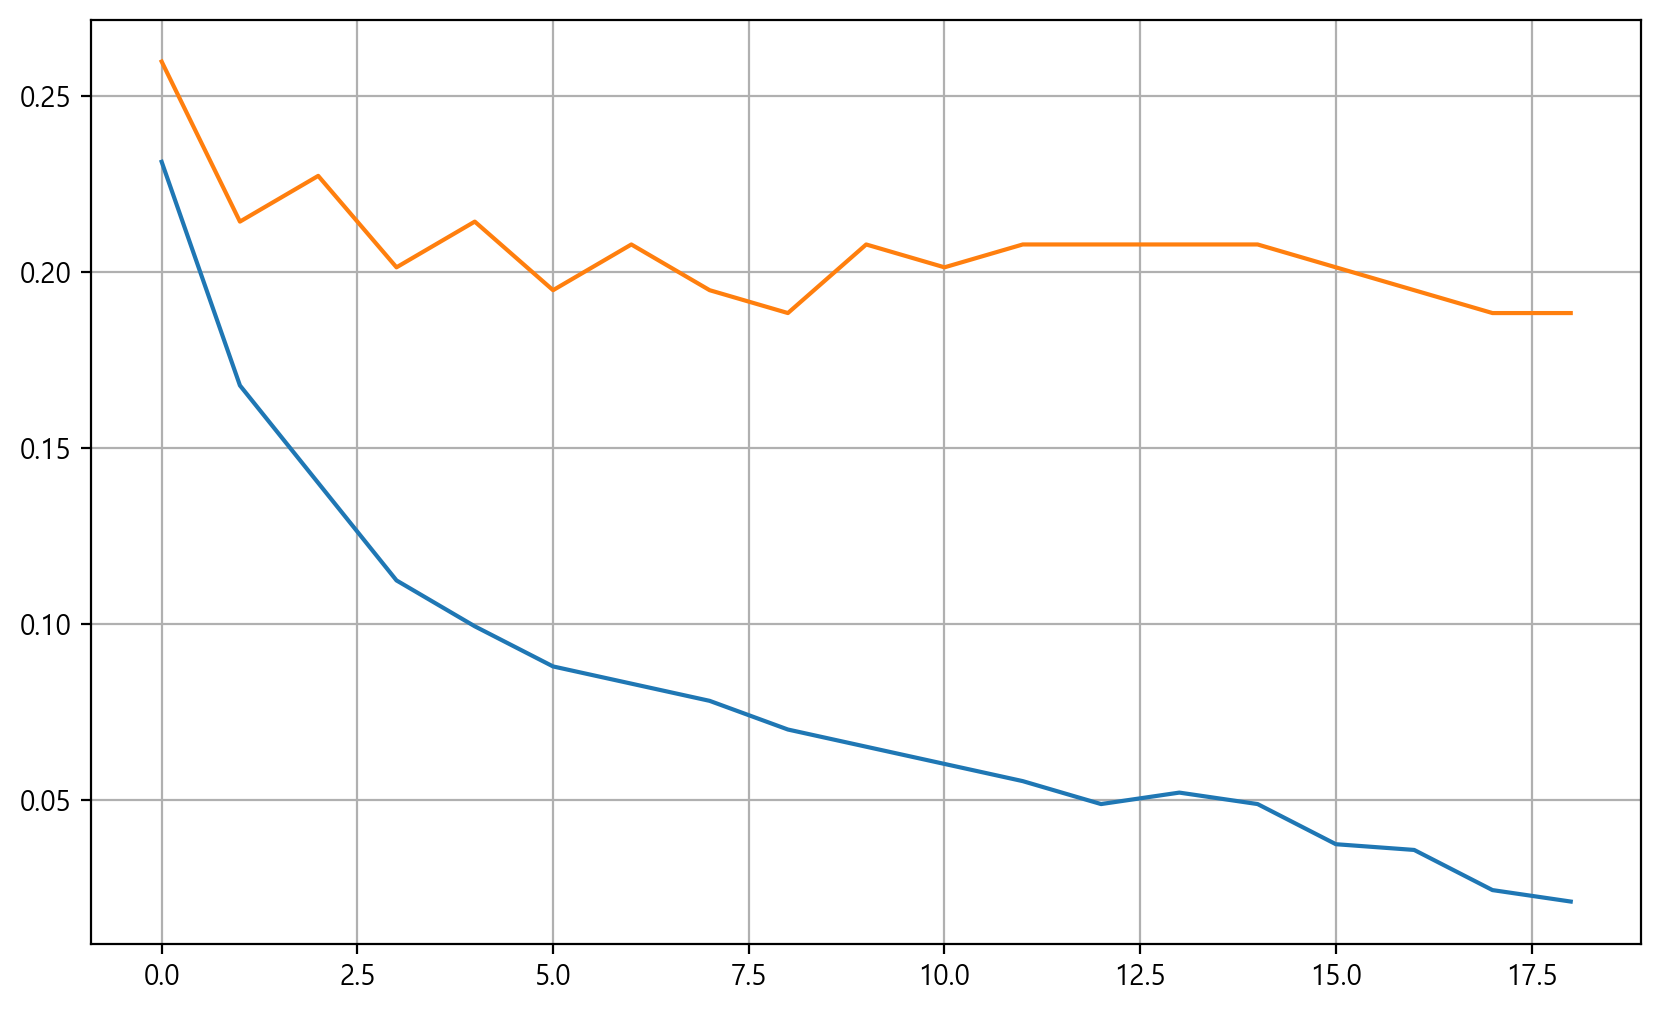

In [16]:
plt.figure()
plt.plot(estimator.evals_result()['validation_0']['error'])
plt.plot(estimator.evals_result()['validation_1']['error'])
plt.grid()
plt.show()

- 변수 중요도를 이용한 변수 필터링 : 모든 변수 중요도를 합친 값의 95%까지 설명하는 변수만 남기고 나머지는 삭제

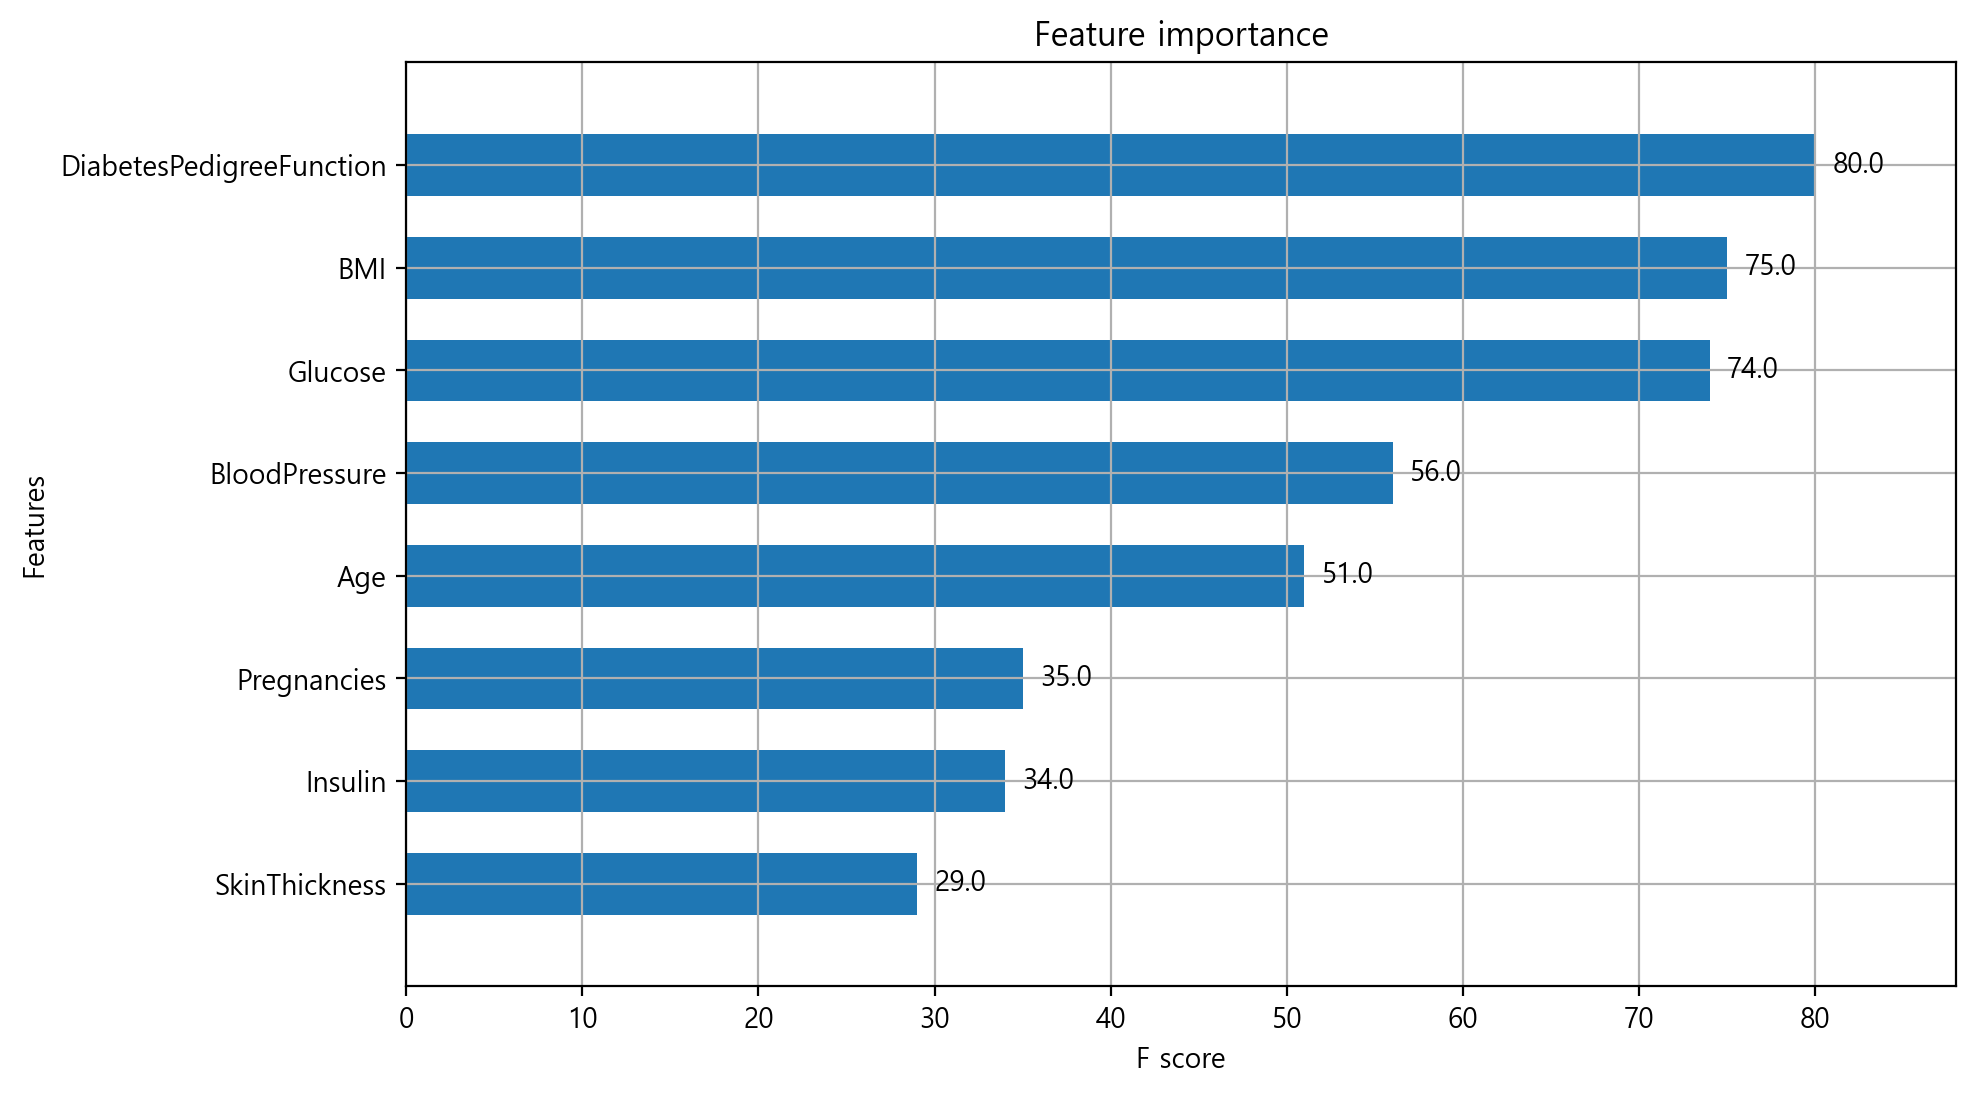

In [17]:
plot_importance(estimator, height = 0.6)
plt.show()

In [18]:
feature_important = estimator.get_booster().get_score(importance_type = 'weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

In [19]:
result_df = pd.DataFrame(values, index = keys, columns = ['score']).sort_values(by = 'score', ascending = False)

result_df['rate'] = result_df['score'] / result_df['score'].sum()
result_df['cumsum'] = result_df['rate'].cumsum()

In [20]:
result_df

,score,rate,cumsum
DiabetesPedigreeFunction,80.0,0.184332,0.184332
BMI,75.0,0.172811,0.357143
Glucose,74.0,0.170507,0.527650
BloodPressure,56.0,0.129032,0.656682
Age,51.0,0.117512,0.774194
Pregnancies,35.0,0.080645,0.854839
Insulin,34.0,0.078341,0.933180
SkinThickness,29.0,0.066820,1.000000


In [21]:
support = YjkClassifierSupport()

사용 가능한 모델 : ['LogisticRegression', 'SGDClassifier', 'KNeighborsClassifier', 'LinearSVC', 'SVC', 'GaussianNB', 'DecisionTreeClassifier', 'RandomForestClassifier', 'AdaBoostClassifier', 'GradientBoostingClassifier', 'XGBClassifier', 'CatboostClassifier']


In [22]:
results = yjk_classifier_multi_gridsearch(support, x_train, y_train, x_test, y_test)

LogisticRegression 모델 소요 시간 : 0:00:00
SGDClassifier 모델 소요 시간 : 0:00:00
KNeighborsClassifier 모델 소요 시간 : 0:00:00
LinearSVC 모델 소요 시간 : 0:00:00
SVC 모델 소요 시간 : 0:00:00
GaussianNB 모델 소요 시간 : 0:00:00
DecisionTreeClassifier 모델 소요 시간 : 0:00:00
RandomForestClassifier 모델 소요 시간 : 0:00:09
AdaBoostClassifier 모델 소요 시간 : 0:00:07
GradientBoostingClassifier 모델 소요 시간 : 0:00:11
XGBClassifier 모델 소요 시간 : 0:00:01
CatboostClassifier 모델 소요 시간 : 0:00:08
총 소요 시간 : 0:00:41


In [23]:
results

,best_model,best_param,accuracy_train,accuracy_test
model_name,,,,
AdaBoostClassifier,"(DecisionTreeClassifier(max_depth=7, random_st...","{'n_estimators': 100, 'learning_rate': 1}",1.000000,0.824675
XGBClassifier,"XGBClassifier(base_score=None, booster=None, c...","{'subsample': 0.75, 'n_estimators': 100, 'min_...",1.000000,0.818182
CatboostClassifier,<catboost.core.CatBoostClassifier object at 0x...,{},0.939739,0.811688
LogisticRegression,"LogisticRegression(C=0.1, n_jobs=-1)","{'penalty': 'l2', 'max_iter': 100, 'C': 0.1}",0.760586,0.805195
SGDClassifier,"SGDClassifier(alpha=0.01, early_stopping=True,...","{'tol': 0.001, 'penalty': 'l2', 'max_iter': 10...",0.770358,0.798701
KNeighborsClassifier,"KNeighborsClassifier(n_jobs=-1, n_neighbors=7)","{'weights': 'uniform', 'p': 2, 'n_neighbors': 7}",0.788274,0.798701
LinearSVC,"LinearSVC(C=0.01, dual=False, max_iter=10000, ...","{'penalty': 'l1', 'max_iter': 10000, 'loss': '...",0.763844,0.798701
SVC,"SVC(C=10, degree=5, kernel='linear')","{'kernel': 'linear', 'degree': 5, 'C': 10}",0.760586,0.798701
GradientBoostingClassifier,([DecisionTreeRegressor(criterion='friedman_ms...,"{'subsample': 0.1, 'n_estimators': 100, 'min_s...",0.822476,0.792208


In [24]:
support.get_params('XGBClassifier')

{'n_estimators': [100, 300],
 'learning_rate': [0.3, 0.5, 0.08, 0.1],
 'min_child_weight': [1, 0.8, 0.5],
 'max_depth': [6, 7, 9, 11, 0],
 'subsample': [0.5, 0.75, 1],
 'colsample_bytree': [0.6, 0.8, 1]}

In [25]:
xgb = results.loc['XGBClassifier', 'best_model']

In [26]:
xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=0, max_leaves=None,
              min_child_weight=0.8, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [27]:
xgb.set_params(reg_alpha = 5)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=0, max_leaves=None,
              min_child_weight=0.8, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

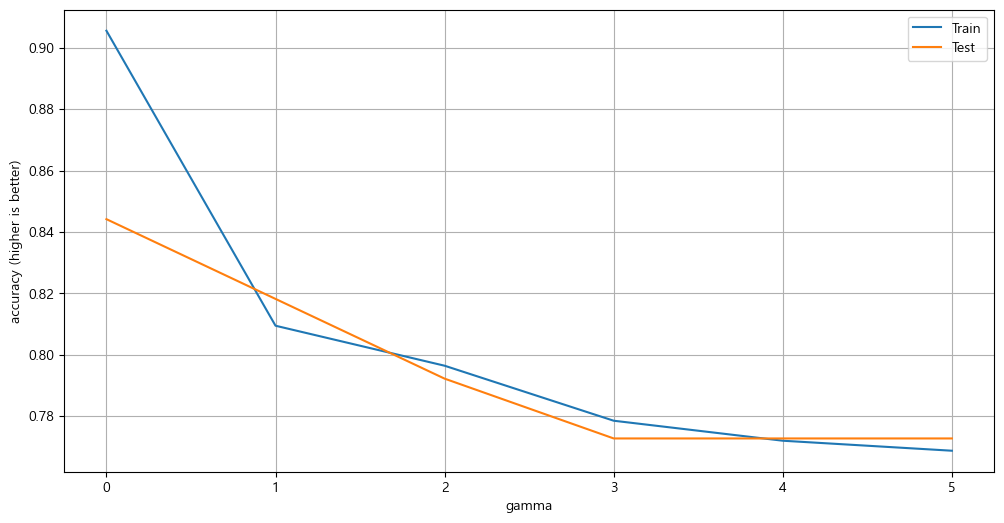

,훈련 데이터,검증 데이터,Min-Max
gamma,,,
0,0.905537,0.844156,최대값
1,0.809446,0.818182,
2,0.796417,0.792208,
3,0.778502,0.772727,최소값
4,0.771987,0.772727,
5,0.768730,0.772727,


In [31]:
yjk_classification_param_plot(xgb, x_train, y_train, 'gamma', range(6), x_test, y_test)